In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
import os
import shutil
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.metrics import classification_report

# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [2]:
df_shoes = pd.read_csv('post_analysis_shoes.csv')
df_shoes.shape

(8064, 18)

In [3]:
def plot_value_counts(df,column,kind,rotation=None):
    if(kind == 'barh'):
        plt.figure(figsize=(10,25))
    else:
        plt.figure(figsize=(16,5))
    (df[column].value_counts()/len(df)).plot(kind=kind,title=f"{column}")
    if(rotation):
        plt.xticks(rotation=rotation)
    plt.show()

In [4]:
popular_brands = ['olympikus', 'under_armour', 'nike', 'adidas', 'mizuno','asics','puma','fila']

df_shoes = df_shoes[df_shoes['brand'].isin(popular_brands)]

['olympikus', 'nike', 'adidas', 'asics', 'puma', 'mizuno', 'fila']


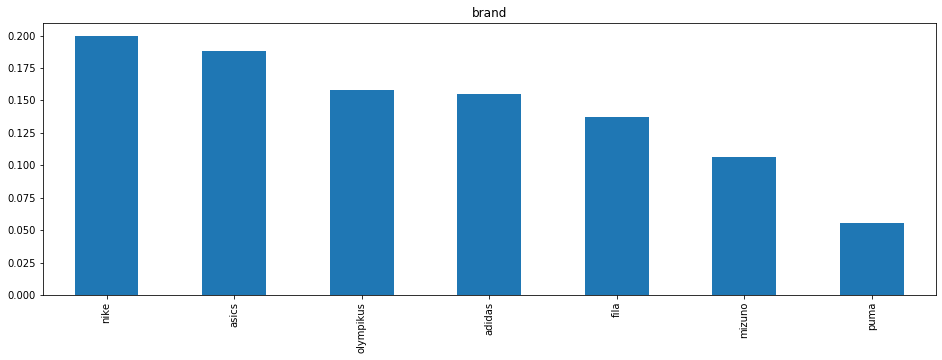

In [5]:
print(list(df_shoes['brand'].unique()))
    
plot_value_counts(df_shoes,'brand','bar')

# Preprocessing Functions

In [6]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
base_path = '/home/raphael/Documents/Projects/netshoes_ml_project/netshoes/images/'
train_image_generator = ImageDataGenerator(rescale=1./255,
                                            rotation_range=45,
                                            width_shift_range=.15,
                                            height_shift_range=.15,
                                            horizontal_flip=True,
                                            zoom_range=0.5)

validation_image_generator = ImageDataGenerator(rescale=1./255)

In [8]:
IMG_SHAPE = (240,240)
epochs = 100

checkpoint_path = './brand_model/drop35_lr1e2_dense256_128_64_elu_sgd_b1'
# shutil.rmtree(checkpoint_path)

In [9]:
efficient_net_url = "https://tfhub.dev/google/efficientnet/b1/feature-vector/1"

drop_rate = 0.35
if(not os.path.exists(checkpoint_path)):
    os.makedirs(checkpoint_path)

    feature_extractor_layer = hub.KerasLayer(efficient_net_url,
                                         input_shape=IMG_SHAPE+(3,))
    feature_extractor_layer.trainable = False

    model = Sequential([
        feature_extractor_layer,
        Dropout(drop_rate),
        BatchNormalization(),
        Dense(256,'elu'),
        Dropout(drop_rate),
        BatchNormalization(),
        Dense(128,'elu'),
        Dropout(0.2),
        BatchNormalization(),
        Dense(64,'elu'),
        Dropout(0.2),
        BatchNormalization(),
        Dense(32,'elu'),
        Dropout(0.1),
        BatchNormalization(),
        Dense(df_shoes['brand'].nunique())
    ])
    initial_epoch = 0
else:
    model = tf.keras.models.load_model(checkpoint_path)
    initial_epoch = epochs

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              6575232   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1280)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 1280)              5120      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               327936    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [9]:
df_shoes['images'] = df_shoes['images'].str.split(',')
df_data = df_shoes.explode('images')[['images','brand']]
df_data['images'] = base_path + df_data['images']
df_data.shape

(17495, 2)

In [10]:
train, valid_test = train_test_split(df_data,
                                test_size=0.15,
                                stratify=df_data['brand'].values,
                                random_state=42)

valid, test = train_test_split(valid_test,
                                test_size=0.25,
                                stratify=valid_test['brand'].values,
                                random_state=42)

train_data_gen = train_image_generator.flow_from_dataframe(train,
                                          x_col='images',
                                          y_col='brand',
                                          shuffle=True,
                                          batch_size=64,
                                          target_size=IMG_SHAPE)

val_data_gen = validation_image_generator.flow_from_dataframe(valid,
                                              x_col='images',
                                              y_col='brand',
                                              shuffle=True,
                                              batch_size=64,
                                              target_size=IMG_SHAPE)

test_data_gen = validation_image_generator.flow_from_dataframe(test,
                                              x_col='images',
                                              y_col='brand',
                                              shuffle=True,
                                              batch_size=64,
                                              target_size=IMG_SHAPE)

Found 14870 validated image filenames belonging to 7 classes.
Found 1968 validated image filenames belonging to 7 classes.
Found 657 validated image filenames belonging to 7 classes.


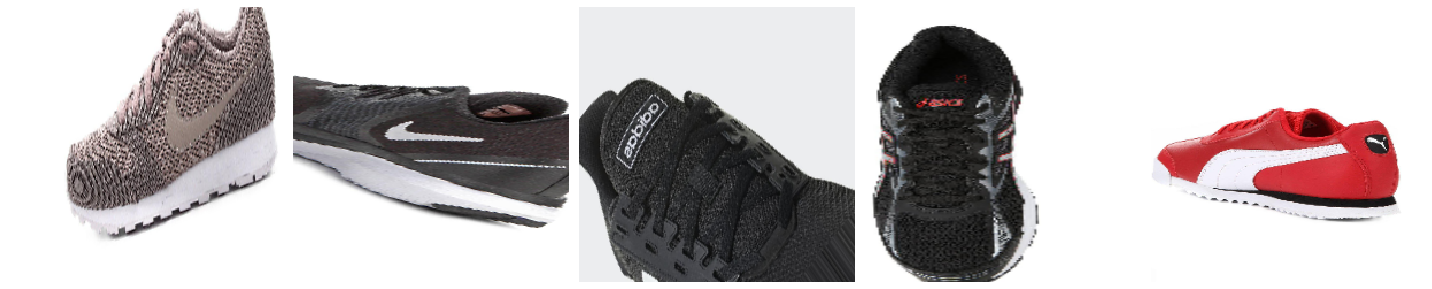

In [11]:
sample_training_images, _ = next(train_data_gen)

plot_images(sample_training_images[:5])

In [13]:
%tensorboard --logdir ./brand_model/drop35_lr1e2_dense256_128_64_elu_sgd_b1

In [32]:
learning_rate = 0.001

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate,momentum=0.9,nesterov=True),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

logdir = f"{checkpoint_path}/logs/5/scalars/"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       save_best_only=True,
                                       monitor='val_acc',
                                       mode='max',
                                       save_weights_only=False),
    tf.keras.callbacks.TensorBoard(log_dir=logdir,profile_batch=0,update_freq='batch')
]



history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // train_data_gen.batch_size,
    epochs=350,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // val_data_gen.batch_size,
    callbacks=callbacks,
    initial_epoch=297
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 232 steps, validate for 30 steps
Epoch 298/350
232/232 [==============================] - 312s 1s/step - loss: 0.6352 - acc: 0.7754 - val_loss: 0.4110 - val_acc: 0.8677
Epoch 299/350
232/232 [==============================] - 309s 1s/step - loss: 0.6374 - acc: 0.7758 - val_loss: 0.4131 - val_acc: 0.8677
Epoch 300/350
232/232 [==============================] - 313s 1s/step - loss: 0.6400 - acc: 0.7749 - val_loss: 0.4124 - val_acc: 0.8682
Epoch 301/350
232/232 [==============================] - 314s 1s/step - loss: 0.6400 - acc: 0.7778 - val_loss: 0.4108 - val_acc: 0.8687
Epoch 302/350
232/232 [==============================] - 313s 1s/step - loss: 0.6317 - acc: 0.7792 - val_loss: 0.4119 - val_acc: 0.8693
Epoch 303/350
232/232 [==============================] - 311s 1s/step - loss: 0.6349 - acc: 0.7790 - val_loss: 0.4110 - val_acc: 0.8656
Epoch 304/350
232/232 [==============================] - 310s 1s/step - loss: 0.6432 - acc:

KeyboardInterrupt: 

In [12]:
model = tf.keras.models.load_model(checkpoint_path)

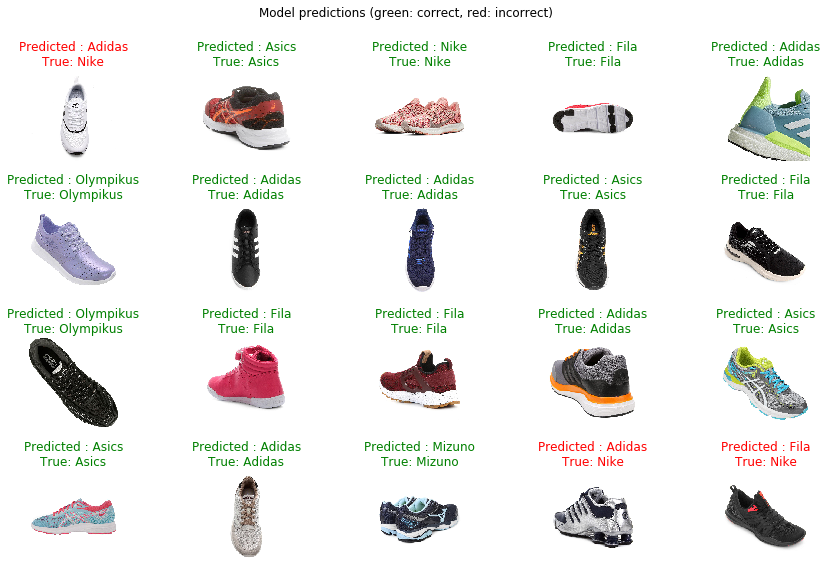

In [13]:
class_names = sorted(train_data_gen.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])

image_batch, label_batch = test_data_gen.next()

predicted_batch = model.predict(image_batch)
real_id = np.argmax(label_batch,axis=-1)
real_label_batch = class_names[real_id]
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(15,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
    plt.subplot(4,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(f"Predicted : {predicted_label_batch[n].title()}\nTrue: {real_label_batch[n].title()}",
              color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")
plt.show()

In [35]:
# Evaluation on whole val set
model.evaluate(val_data_gen)

# Evaluation on whole test set
model.evaluate(test_data_gen)

  ...
    to  
  ['...']
31/31 [==============================] - 25s 808ms/step - loss: 0.4052 - acc: 0.8709
  ...
    to  
  ['...']
11/11 [==============================] - 8s 760ms/step - loss: 0.4100 - acc: 0.8706


[0.41000443967905914, 0.87062407]

Best:  
    loss: 0.4052 - acc: 0.8709   
    loss: 0.4100 - acc: 0.8706

In [13]:
def report(data_gen,model):
    real= []
    predicted = []
    steps = data_gen.samples // data_gen.batch_size
    data_gen.reset()
    for step in tqdm_notebook(range(steps)):
        image_batch, label_batch = data_gen.next()
        predicted_batch = model.predict(image_batch)

        real_id = np.argmax(label_batch,axis=-1)
        real_label_batch = class_names[real_id]

        predicted_id = np.argmax(predicted_batch, axis=-1)
        predicted_label_batch = class_names[predicted_id]

        real.extend(real_label_batch)
        predicted.extend(predicted_label_batch)

    print(classification_report(real,predicted))

In [14]:
report(val_data_gen,model)


              precision    recall  f1-score   support

      Adidas       0.87      0.87      0.87       315
       Asics       0.88      0.90      0.89       362
        Fila       0.84      0.83      0.83       253
      Mizuno       0.93      0.92      0.93       208
        Nike       0.84      0.86      0.85       382
   Olympikus       0.87      0.95      0.91       298
        Puma       0.94      0.60      0.73       102

    accuracy                           0.87      1920
   macro avg       0.88      0.85      0.86      1920
weighted avg       0.87      0.87      0.87      1920



In [15]:
report(test_data_gen,model)


              precision    recall  f1-score   support

      Adidas       0.89      0.80      0.84       105
       Asics       0.86      0.96      0.91       122
        Fila       0.82      0.86      0.84        84
      Mizuno       0.98      0.92      0.95        71
        Nike       0.81      0.82      0.82       125
   Olympikus       0.91      0.95      0.93        98
        Puma       0.89      0.69      0.77        35

    accuracy                           0.87       640
   macro avg       0.88      0.86      0.87       640
weighted avg       0.87      0.87      0.87       640



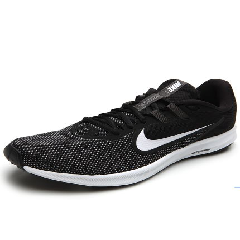

In [30]:
img = tf.keras.preprocessing.image.load_img("external_images/nike-tênis-nike-downshifter-9-preto-3602-0019074-1-zoom.jpg",
                                            target_size=(240,240))
img_array = tf.keras.preprocessing.image.img_to_array(img).reshape(1,240,240,3)
img

In [31]:
class_names[model.predict_classes(img_array)]

array(['Nike'], dtype='<U9')

In [29]:
class_names

array(['Adidas', 'Asics', 'Fila', 'Mizuno', 'Nike', 'Olympikus', 'Puma'],
      dtype='<U9')